# The Happy Citizen Classissification Model

## Library Imports:

In [1]:
import pandas as pd
import numpy as np
import zipfile
import requests
import re
from copy import deepcopy
from collections import defaultdict
from savReaderWriter import SavReader
from savReaderWriter import SavHeaderReader

In [2]:
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.figure_factory as ff
from plotly.graph_objs import *
import time
%matplotlib inline

In [3]:
from sklearn.tree import export_graphviz

In [4]:
from sklearn.model_selection import KFold,cross_val_score,cross_val_predict,GridSearchCV

In [5]:
from sklearn.metrics import confusion_matrix,roc_curve

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.dummy import DummyClassifier

In [7]:
# Initializing a list of colors for plotting later on
colors_for_plots = ['firebrick','darkgreen','blue','mediumvioletred','darkorchid','black','orangered','dodgerblue','darkolivegreen','magenta']
colors_for_plots_2 = ['indianred','mediumseagreen','royalblue','violet','plum','dimgray','darkorange','lightskyblue','olivedrab','hotpink']

The raw data can be found and downloaded from the [PEW Website](http://www.pewglobal.org/2014/06/05/spring-2014-survey-data/). The downloaded folder is in zip format and contains a .sav file which holds our raw data

Create a directory to hold downloaded files if you haven't already

```python
!mkdir ../../temp_files_projects
```

In [ ]:
#extracting the zip file and convertin the .sav file into a pandas dataframe
pew_zip_path = '/home/farhaan/Downloads/pew-global-14-questions.zip'
zf = zipfile.ZipFile(pew_zip_path)
zf.extract('Pew Research Global Attitudes Spring 2014 Dataset for web.sav',path='../../temp_files_projects')

This raw data can be turned into a dataframe.

In [8]:
df_raw= pd.DataFrame(list(SavReader('../../temp_file_projects/Pew Research Global Attitudes Spring 2014 Dataset for web.sav')))

We can pickle the dataframe for future use.

```python
df_raw.to_pickle('/home/farhaan/ds/metis/metisgh/Test_box/03_Rough_folder/raw_data_df.p')
```

In [10]:
#Have a HUGE dataset with 1150 columns and 48643 original entries
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48643 entries, 0 to 48642
Columns: 1150 entries, 0 to 1149
dtypes: float64(1087), object(63)
memory usage: 426.8+ MB


In [11]:
# The original column names are of no use to us since we have no idea
# what it condains if it just have a column index value as the label
df_raw.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,1140,1141,1142,1143,1144,1145,1146,1147,1148,1149
19296,119359.0,4.0,1.0,10.0,NaN,10.0,98.0,10.0,10.0,10.0,...,NaN,NaN,b'',NaN,NaN,NaN,NaN,1.534343,4073.0,4021.0
46083,146173.0,37.0,1.0,2.0,NaN,3.0,98.0,3.0,5.0,3.0,...,NaN,NaN,b'',NaN,NaN,NaN,NaN,1.217863,37076.0,37005.0
1443,101443.0,10.0,1.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,b'',NaN,NaN,NaN,NaN,1.930787,10001.0,10035.0
4784,104784.0,30.0,3.0,6.0,NaN,4.0,5.0,5.0,8.0,1.0,...,NaN,NaN,b'',NaN,NaN,NaN,NaN,0.658816,121981960.0,30051.0
30916,131006.0,8.0,1.0,8.0,NaN,8.0,8.0,10.0,10.0,8.0,...,NaN,NaN,b'',NaN,NaN,NaN,NaN,0.949868,8048.0,8025.0


In [12]:
#Trying to read and decipher the .sav file headers
with SavHeaderReader('/home/farhaan/ds/metis/metisgh/Test_box/03_Rough_folder/Pew Research Global Attitudes Spring 2014 Dataset for web.sav') as header:
    metadata = header.all()
    print(metadata.varLabels)

{b'PSRAID': b'PSRAI ID', b'COUNTRY': b'Country', b'Q1': b'Q1. To begin, how would you describe your day today\xe2\x80\x94has it been a typical day, a particularly good day, or a particularly bad day? ', b'Q2A': b"Q2A. Here is the 'ladder of life' The top of the ladder represents the best possible life for you; and the bottom, the worst possible life for you.  On which step of the ladder do you feel you personally stand at the present time?", b'Q2B': b'Q2B. Imagine a ladder with steps numbered from 0 at the bottom to 10 at the top.  The top represents the best possible life for you; the bottom, the worst possible life.  On which step do you feel you personally stand at present time?', b'Q3A': b'Q3A. On which step would you say you stood five years ago?  ', b'Q3B': b'Q3B. Just your best guess, on which step do you think you will stand in the future, say five years from now?', b'Q4A': b'Q4A. On a scale of 0 to 10 how satisfied are you with each of the following items, where 0 means you ar

After a fair amount of time spent comparing the original pew questionnaire and the above metadata jumble,
Turns out the metadata contains information about the questions in the survey such as: full question, answer options, etc.
Notably the length of the first element of the metadata is the same as the number of columns in the raw dataframe.
Coincidence? I think not!

In [13]:
#Getting a list of all the Question names so that the columns may be renamed
# The question names are in byte format so I am 'decode'-ing them to read as utf-8 strings
q_names_all = []
for ind , qname in enumerate(list(metadata)[0]):
    q_names_all.append(qname.decode())

#Let's go ahead and rename the columns of the raw dataframe for readability    
df_raw.columns = q_names_all

In [14]:
# I want to create an easily queriable dictionary with full survey question
# wording and possible responses
q_full_dict = defaultdict(dict)
for key,value in list(metadata)[3].items():
    q_full_dict[key.decode()]=value

    
q_responses_dict = defaultdict(dict)
for key,value in list(metadata)[2].items():
    q_responses_dict[key.decode()]=value

# Super-basic data-cleaning

In [15]:
#A quick info method on the raw dataframe shows that we have a fair number of dtype "objects"
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48643 entries, 0 to 48642
Columns: 1150 entries, PSRAID to stratum
dtypes: float64(1087), object(63)
memory usage: 426.8+ MB


In [16]:
#Cross-referencing these with the survey question codes shows that
#these are not questions of interest for this project
#thus we will create a new dataframe that excludes these columns
print("List of excluded columns\n",list(df_raw.select_dtypes(include=[object]).columns))

non_object_cols_df = df_raw.select_dtypes(exclude=[object])

List of excluded columns
 ['QRELARGA', 'QRELBANA', 'QRELBANB', 'QRELBRAB', 'QRELBRIA', 'QRELCHIA', 'QRELCOLA', 'QRELEGYA', 'QRELEGYB', 'QRELESAA', 'QRELFRAA', 'QRELGERA', 'QRELGHAA', 'QRELGREA', 'QRELINDB', 'QRELINDOB', 'QRELISRA', 'QRELISRB', 'QRELIITAA', 'QRELJPNA', 'QRELJPNB', 'QRELJORA', 'QRELJORB', 'QRELKENA', 'QRELLEBA', 'QRELLEBB', 'QRELMALA', 'QRELMALB', 'QRELMEXA', 'QRELNICA', 'QRELNIGA', 'QRELPAKA', 'QRELPAKB', 'QRELPALA', 'QRELPALB', 'QRELPERA', 'QRELPHIA', 'QRELPOLA', 'QRELRUSA', 'QRELSENA', 'QRELSENB', 'QRELRSAa', 'QRELSPAA', 'QRELTANA', 'QRELTUNB', 'QRELTURA', 'QRELTURB', 'QRELUGAA', 'QRELUSA', 'QRELUKRB', 'QRELVENB', 'QRELVIEA', 'QRELVIEB', 'Q96A_1OTH', 'Q96A_2OTH', 'Q96A_3OTH', 'Q96B_1OTH', 'Q96B_2OTH', 'Q96B_3OTH', 'Q138BPHI', 'RACE3M4', 'RACEOS', 'USR']


## Attention!

Q2A and Q2B are a measure of the target dependent variables:
An indicator of how satisfied people are with their life.


They are esentially, the same question but one (Q2A) is for people
interviewed in person whereas (Q2B) is for people that were
interviewed over the phone.
- Note there are a lot more people who did in-person interviews than phone interviews

In [17]:
print(f'Face-to-face non-null Interview responses to Q2: {non_object_cols_df.loc[:,["Q2A"]].notnull().sum()[0]}')
print(f'Telephone non-null Interview responses to Q2: {non_object_cols_df.loc[:,["Q2B"]].notnull().sum()[0]}')

Face-to-face non-null Interview responses to Q2: 40620
Telephone non-null Interview responses to Q2: 7023


In [18]:
non_object_cols_df.loc[:,['Q2A','Q2B']].sample(15,random_state=40)

,Q2A,Q2B
21683,8.0,NaN
1516,NaN,8.0
30540,5.0,NaN
21385,6.0,NaN
28072,5.0,NaN
1295,NaN,8.0
31490,6.0,NaN
8597,10.0,NaN
10399,5.0,NaN
47992,8.0,NaN


In order to accurately analyze this data,
we need a column that contains the responses of Q2A AND Q2B,
whichever one was used to find out the target response.
So, let's create a new column 'Q2agg' with just that information.
And then drop any rows that still have NaN values for 'Q2Agg'

In [19]:
choice_columns=['Q2A, Q2B']
def pick_cell_with_notnull_value(row):
    if pd.notnull(row['Q2A']):
        return row['Q2A']
    elif pd.notnull(row['Q2B']):
        return row['Q2B']
    else:
        return None

non_object_cols_df['Q2agg']=non_object_cols_df.apply(pick_cell_with_notnull_value,axis=1)
non_object_cols_df=non_object_cols_df.dropna(axis=0,subset=['Q2agg'])
#also remove 98 "Don't know" and 99 Refused"  values from dataset
non_object_cols_df = non_object_cols_df[non_object_cols_df['Q2agg']<=10]

/home/farhaan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Unfortunately, a lot of the data columns have information that were country-specific or didn't contain data that might be 'useful' in creating a model.

So, I'm removing those questions, and focusing on a select questions on which to perform analysis.

In [20]:
#Selecting columns of interest to be used in analysis
desired_cols= ['Q2agg','COUNTRY','Q5','Q9','Q10','Q11','Q13A','Q13B','Q23A','Q23B','Q23C','Q23D','Q27',
               'Q28','Q30','Q66A','Q66B','Q66C','Q66D','Q66E','Q66F','Q66G','Q77B','Q132','Q133','Q153']

desired_cols_df = non_object_cols_df[desired_cols]

In [21]:
#Much lesser memory usage since so many columns were dropped!
desired_cols_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47418 entries, 0 to 48642
Data columns (total 26 columns):
Q2agg      47418 non-null float64
COUNTRY    47418 non-null float64
Q5         47418 non-null float64
Q9         47418 non-null float64
Q10        47418 non-null float64
Q11        47418 non-null float64
Q13A       47418 non-null float64
Q13B       47418 non-null float64
Q23A       47418 non-null float64
Q23B       47418 non-null float64
Q23C       47418 non-null float64
Q23D       47418 non-null float64
Q27        47418 non-null float64
Q28        47418 non-null float64
Q30        47418 non-null float64
Q66A       47418 non-null float64
Q66B       47418 non-null float64
Q66C       47418 non-null float64
Q66D       47418 non-null float64
Q66E       47418 non-null float64
Q66F       47418 non-null float64
Q66G       47418 non-null float64
Q77B       47418 non-null float64
Q132       47418 non-null float64
Q133       47418 non-null float64
Q153       47418 non-null float64
dtypes:

In [22]:
#Cleaning rows where respondent of refusal to answer questions
cleaned_df = deepcopy(desired_cols_df)
cleaned_df = cleaned_df[cleaned_df['Q5']!=9]
# cleaned_df = cleaned_df[cleaned_df['Q10']!=9]
# cleaned_df = cleaned_df[cleaned_df['Q11']!=9]
# cleaned_df = cleaned_df[cleaned_df['Q13A']!=9]
# cleaned_df = cleaned_df[cleaned_df['Q13B']!=9]
# cleaned_df = cleaned_df[cleaned_df['Q23A']!=9]
# cleaned_df = cleaned_df[cleaned_df['Q23B']!=9]
# cleaned_df = cleaned_df[cleaned_df['Q23C']!=9]
# cleaned_df = cleaned_df[cleaned_df['Q23D']!=9]
# cleaned_df = cleaned_df[cleaned_df['Q27']!=9]
# cleaned_df = cleaned_df[cleaned_df['Q28']!=9]
# cleaned_df = cleaned_df[cleaned_df['Q30']!=9]
cleaned_df = cleaned_df[cleaned_df['Q66A']!=98]
cleaned_df = cleaned_df[cleaned_df['Q66B']!=98]
cleaned_df = cleaned_df[cleaned_df['Q66C']!=98]
cleaned_df = cleaned_df[cleaned_df['Q66D']!=98]
cleaned_df = cleaned_df[cleaned_df['Q66E']!=98]
cleaned_df = cleaned_df[cleaned_df['Q66F']!=98]
cleaned_df = cleaned_df[cleaned_df['Q66G']!=98]
cleaned_df = cleaned_df[cleaned_df['Q66A']!=99]
cleaned_df = cleaned_df[cleaned_df['Q66B']!=99]
cleaned_df = cleaned_df[cleaned_df['Q66C']!=99]
cleaned_df = cleaned_df[cleaned_df['Q66D']!=99]
cleaned_df = cleaned_df[cleaned_df['Q66E']!=99]
cleaned_df = cleaned_df[cleaned_df['Q66F']!=99]
cleaned_df = cleaned_df[cleaned_df['Q66G']!=99]
cleaned_df = cleaned_df[cleaned_df['Q133']<=97]

In [23]:
#After cleaning, the data has shrunk slightly from ~47400 to ~44100
cleaned_df.shape

(44899, 26)

In [24]:
# The distribution of the satisfaction ratings where 10 is the highest and 0 is the lowest is as such:
cleaned_df['Q2agg'].value_counts()

7.0     8622
5.0     8317
8.0     7406
6.0     7068
4.0     3380
9.0     2847
10.0    2785
3.0     2187
2.0     1117
1.0      607
0.0      563
Name: Q2agg, dtype: int64

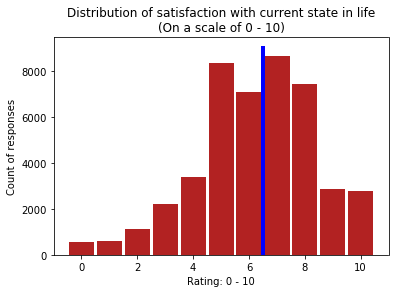

In [25]:
#This is the distribution of numerical satisfaction ratings
plt.hist(cleaned_df.loc[:,'Q2agg'],bins=11,range=(0,11),align='left',color=colors_for_plots[0],rwidth=0.9)
plt.title("Distribution of satisfaction with current state in life\n(On a scale of 0 - 10)")
plt.xlabel("Rating: 0 - 10")
plt.ylabel("Count of responses")
plt.plot([6.5, 6.5], [0, 9000], 'b-', lw=4)

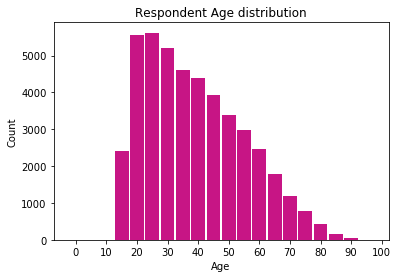

In [26]:
#This is the distribution of ages of repondents
plt.hist(cleaned_df.loc[:,'Q133'],bins=20,range=(0,100),align='left',color=colors_for_plots[3],rwidth=0.9)
plt.title("Respondent Age distribution")
plt.xticks(np.arange(0,110,10))
plt.xlabel("Age")
plt.ylabel("Count")

**Separation into classes**

It seems like around half the population had ratings between 0 and 6 and another half had rating between 7 and 10.
Arguably, this boundary can serve as a means to distinguish between respondents that were *Satisfied* with their perceived position on the 'ladder of life' and those that were *Dissatisfied*.

In [27]:
#giving a satisfaction rating of Satisfied/Unsatisfied based on answer to Q2 ('Q2agg')
def satisfaction_rating(row):
    # Q2agg of 7 or higher
    if row['Q2agg']>=7:
        return "Satisfied"
    # Q2agg of 0-6
    else:
        return "Dissatisfied"
    
cleaned_df['satisfaction_rating']=cleaned_df.apply(satisfaction_rating,axis=1)

In [28]:
sat_dissat_split = pd.Series(cleaned_df.iloc[:,-1].value_counts(normalize=True))
print(f'Respondents that were {sat_dissat_split.index[0]} with their current lot in life: {str(sat_dissat_split[0]*100)[0:4]}%')
print(f'Respondents that were {sat_dissat_split.index[1]} with their current lot in life: {str(sat_dissat_split[1]*100)[0:4]}%')

Respondents that were Dissatisfied with their current lot in life: 51.7%
Respondents that were Satisfied with their current lot in life: 48.2%


In [29]:
cleaned_df.sample(5,random_state=40)

,Q2agg,COUNTRY,Q5,Q9,Q10,Q11,Q13A,Q13B,Q23A,Q23B,...,Q66C,Q66D,Q66E,Q66F,Q66G,Q77B,Q132,Q133,Q153,satisfaction_rating
40638,8.0,1.0,1.0,2.0,3.0,3.0,2.0,3.0,1.0,2.0,...,8.0,0.0,3.0,3.0,10.0,1.0,2.0,76.0,1.0,Satisfied
36177,8.0,39.0,1.0,2.0,3.0,2.0,2.0,1.0,1.0,1.0,...,10.0,10.0,9.0,9.0,10.0,2.0,2.0,45.0,1.0,Satisfied
1587,8.0,10.0,1.0,2.0,3.0,1.0,3.0,2.0,2.0,2.0,...,9.0,2.0,4.0,6.0,6.0,2.0,1.0,60.0,1.0,Satisfied
1730,7.0,10.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,8.0,0.0,3.0,0.0,8.0,1.0,1.0,35.0,1.0,Satisfied
23427,9.0,3.0,1.0,2.0,2.0,1.0,3.0,2.0,1.0,1.0,...,9.0,10.0,10.0,10.0,10.0,2.0,1.0,26.0,6.0,Satisfied


### Generating Clean data sets for initial analysis (including Dummy Variables)

## Generating Dummy variables
**Requires finnesse**

The cleaned_df dataframe will be used to create the dummy variables

In [30]:
dummies_df = pd.concat([cleaned_df.iloc[:,-1:],cleaned_df.iloc[:,:-1]],axis=1)

In [31]:
# Questions to be turned into standardized variables and corresponding thresholds of original responses
# to standardize them
old_q_and_threshold_list = [
    ('Q5', 2), #not satisfied with current affairs of country
    ('Q9', 4), #country economic condition relatively bad
    ('Q10', 5), #expect that country economic condition will be worse in 10 months
    ('Q11', 4), #think children will be worse off than them financially
    ('Q13A', 4), #do not believe people are better off in a free market economy
    ('Q13B', 4), #do not believe success in life is determined by forces out of our control
    ('Q23A', 4), #do not believe rising prices in country are a relatively big problem
    ('Q23B', 4), #do not believe lack of employment opportunities in country are a relatively big problem
    ('Q23C', 4), #do not believe gap between rich and poor in country is a relatively big problem
    ('Q23D', 4), #do not believe public debt in country is a relatively big problem
    ('Q27', 4), #do not believe growing trade between their countries and others is a good thing
    ('Q28', 2), #do not believe trade with other countries leads to an increase in wages
    ('Q30', 2), #do not believe trade with other countries leads to increases in price of products sold
    ('Q66A', 10), #believe good information is relatively important to get ahead in life
    ('Q66B', 10), #believe working hard is relatively important to get ahead in life
    ('Q66C', 10), #believe knowing the right people is relatively important to get ahead in life
    ('Q66D', 10), #believe giving bribes is relatively important to get ahead in life
    ('Q66E', 10), #believe being male is relatively important to get ahead in life
    ('Q66F', 10), #believe belonging to a wealthy family is relatively important to get ahead in life
    ('Q66G', 10), #believe being lucky is relatively important to get ahead in life
    ('Q132', 1), #is a male - binary
    ('Q133', 97), #age
    ('Q153', 1)] #is married - binary

In [32]:
#creation of standardized variables
threshhold=0
def set_standardized_variable_value(row):
    if threshhold ==1:              # special case for dummy 'binary' variables
        if row[question]==1:
            return 1
        elif row[question]==0:
            return 0
        else:
            return 0.5
    elif threshhold > 90:              #special case for age standardization
        if row[question]<=97:
            return row[question]/threshhold
        else:
            return (25+50*np.random.rand())/threshhold
    elif threshhold<=5:
        if row[question] <= threshhold:
            return (row[question]-1)/(threshhold-1)
        else:
            return 0.5
    else:
        return row[question]/threshhold

for ind,old_question_variable in enumerate(old_q_and_threshold_list):
    question=old_question_variable[0]
    threshhold = old_question_variable[1]
    dummies_df[question]=dummies_df.apply(set_standardized_variable_value,axis=1)

## Dataframe with standardized and dummy variables with response

In [33]:
dummies_df.sample(7,random_state=40)

,satisfaction_rating,Q2agg,COUNTRY,Q5,Q9,Q10,Q11,Q13A,Q13B,Q23A,...,Q66B,Q66C,Q66D,Q66E,Q66F,Q66G,Q77B,Q132,Q133,Q153
40638,Satisfied,8.0,1.0,0.0,0.333333,0.50,0.666667,0.333333,0.666667,0.000000,...,1.0,0.8,0.0,0.3,0.3,1.0,1.0,0.5,0.783505,1.0
36177,Satisfied,8.0,39.0,0.0,0.333333,0.50,0.333333,0.333333,0.000000,0.000000,...,1.0,1.0,1.0,0.9,0.9,1.0,2.0,0.5,0.463918,1.0
1587,Satisfied,8.0,10.0,0.0,0.333333,0.50,0.000000,0.666667,0.333333,0.333333,...,1.0,0.9,0.2,0.4,0.6,0.6,2.0,1.0,0.618557,1.0
1730,Satisfied,7.0,10.0,0.0,0.333333,0.25,0.333333,0.333333,0.333333,0.333333,...,1.0,0.8,0.0,0.3,0.0,0.8,1.0,1.0,0.360825,1.0
23427,Satisfied,9.0,3.0,0.0,0.333333,0.25,0.000000,0.666667,0.333333,0.000000,...,0.9,0.9,1.0,1.0,1.0,1.0,2.0,1.0,0.268041,0.5
41993,Satisfied,8.0,15.0,0.0,0.000000,0.50,0.666667,0.333333,1.000000,0.333333,...,0.8,0.9,0.0,0.5,0.4,0.6,2.0,1.0,0.484536,1.0
41146,Satisfied,7.0,1.0,1.0,1.000000,0.25,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,0.0,1.0,0.3,0.9,2.0,0.5,0.288660,0.5


In [34]:
# X and y to be inputted into models
X= dummies_df.iloc[:,3:]
y= dummies_df.loc[:,'satisfaction_rating']

In [35]:
#will be using this extensively as the cross-validation set
cross_validator= KFold(n_splits=10, shuffle=True, random_state=40)

In [36]:
#A Dictionary containing the names of all the models
model_str_dict = {'dummy':"Always Guess\nDissatisfied",'decision':"Decision\nTree",'knn':"k Nearest\nNeighbors",'randomf':"Random\nForest",'logr':"Logistic\nRegression",'linsvc':"Linear\nSVC"}

In [37]:
model_scores_list=[]

#The Baseline Dummy Classifier Model - Everyone is dissatisfied
dummyclassifiermodel = DummyClassifier(strategy='most_frequent',random_state=40)
dummy_score = cross_val_score(dummyclassifiermodel,X,y,cv=cross_validator, n_jobs=-1).mean()
print(f"Score of DummyClassifier Model = {dummy_score}")
model_scores_list.append((model_str_dict['dummy'],dummy_score))

#Decision Tree Classifier Model
decisiontree = DecisionTreeClassifier(random_state=40)
decisiontree_score = cross_val_score(decisiontree,X,y,cv=cross_validator, n_jobs=-1).mean()
print(f"Score of Decision Tree Model = {decisiontree_score}")
model_scores_list.append((model_str_dict['decision'],decisiontree_score))

#Random Forest Classifier Model
randomforest = RandomForestClassifier(random_state=40,n_jobs=-1)
randomforest_score = cross_val_score(randomforest,X,y,cv=cross_validator).mean()
print(f"Score of Random Forest Model = {randomforest_score}")
model_scores_list.append((model_str_dict['randomf'],randomforest_score))

#Logistic Regression Classifier Model
logregression = LogisticRegression(random_state=40,n_jobs=-1)
logregression_score = cross_val_score(logregression,X,y,cv=cross_validator).mean()
print(f"Score of Logistic Regression Model = {logregression_score}")
model_scores_list.append((model_str_dict['logr'],logregression_score))

#K Nearest Neighbors Classifier
knn = KNeighborsClassifier(n_jobs=-1)
knn_score = cross_val_score(knn,X,y,cv=cross_validator).mean()
print(f"Score of KNN Model = {knn_score}")
model_scores_list.append((model_str_dict['knn'],knn_score))

#Linear SVC Classifier Model
linearsvc = LinearSVC(random_state=40)
linearsvc_score = cross_val_score(linearsvc,X,y,cv=cross_validator).mean()
print(f"Score of Linear SVC Model = {linearsvc_score}")
model_scores_list.append((model_str_dict['linsvc'],linearsvc_score))

Score of DummyClassifier Model = 0.517583923284882
Score of Decision Tree Model = 0.5465824105546793
Score of Random Forest Model = 0.5797234219157843
Score of Logistic Regression Model = 0.6017283227845747
Score of KNN Model = 0.5697452520662981
Score of Linear SVC Model = 0.6015056155581497


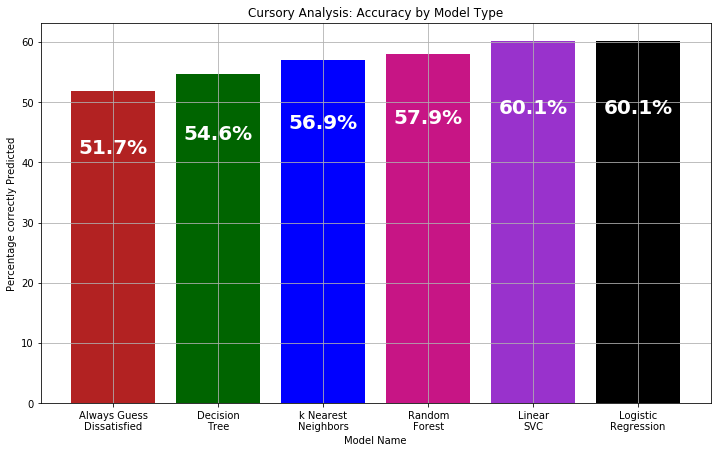

In [38]:
model_scores_list.sort(key= lambda x: x[1])
model_values = [100*value[1] for value in model_scores_list]
model_names = [value[0] for value in model_scores_list]
x_dist = np.linspace(1,len(model_values),num=len(model_values))
fig, ax = plt.subplots(figsize=(12,7))
ax.grid()

text_settings={'color':'white', 'fontweight':'bold','fontsize':20}
bar_width=0.8

plt.bar(x_dist,model_values,width=bar_width,color=colors_for_plots[:len(model_values)])
plt.xticks(x_dist,model_names)
plt.title("Cursory Analysis: Accuracy by Model Type")
plt.xlabel('Model Name')
plt.ylabel('Percentage correctly Predicted')
for ind,score in enumerate(model_values):
    ax.text(x_dist[ind],.8*score,str(score)[:4]+'%',ha='center',**text_settings)

### Hyperparameter optimization
**This calls for a grid CV to optimize parameters.** Time to bring out the big guns. A lot of computations and parameters were tested using GridSearch CV. The best settings are used to run the regressions below.

I don't have a set of CV values that I used in to optimize the hyperparameters. It was very iterative in nature. There may very well exist hyperparameters that will increase the model accuracy even more, but the resulting increase may be small.

In [39]:
# models with dummy variables modified from original
model_scores_list_2=[]

#The Baseline Dummy Classifier Model - Everyone is dissatisfied
# dummyclassifiermodel = DummyClassifier(strategy='most_frequent',random_state=40)
# dummy_score_2 = cross_val_score(dummyclassifiermodel,X,y,cv=cross_validator).mean()
# print(f"Score of DummyClassifier Model = {dummy_score_2}")
print(f"Score of Unoptimized Dummy Model = {dummy_score}")
model_scores_list_2.append((model_str_dict['dummy'],dummy_score,dummy_score))

#Decision Tree Classifier Model
# decisiontree = DecisionTreeClassifier(random_state=40)
# decisiontree_score_2 = cross_val_score(decisiontree,X,y,cv=cross_validator).mean()
# print(f"Score of Decision Tree Model = {decisiontree_score_2}")
print(f"Score of Unoptimized Decision Tree Model = {decisiontree_score}")
model_scores_list_2.append((model_str_dict['decision'],decisiontree_score,decisiontree_score))

#Random Forest Classifier Model
randomforest = RandomForestClassifier(random_state=40,n_jobs=-1,n_estimators=45,max_depth=11,
                                      min_samples_leaf=32,min_samples_split=15)
randomforest_score_2 = cross_val_score(randomforest,X,y,cv=cross_validator).mean()
print(f"Score of Random Forest Model = {randomforest_score_2}")
model_scores_list_2.append((model_str_dict['randomf'],randomforest_score_2,randomforest_score))

#Logistic Regression Classifier Model
logregression = LogisticRegression(random_state=40,n_jobs=-1,C=0.6309,penalty='l2')
logregression_score_2 = cross_val_score(logregression,X,y,cv=cross_validator).mean()
print(f"Score of Logistic Regression Model = {logregression_score_2}")
model_scores_list_2.append((model_str_dict['logr'],logregression_score_2,logregression_score))

#K Nearest Neighbors Classifier
knn = KNeighborsClassifier(n_jobs=-1,n_neighbors=40,weights='uniform',leaf_size=40,algorithm='ball_tree')
knn_score_2 = cross_val_score(knn,X,y,cv=cross_validator).mean()
print(f"Score of KNN Model = {knn_score_2}")
model_scores_list_2.append((model_str_dict['knn'],knn_score_2,knn_score))

#Linear SVC Classifier Model
linearsvc = LinearSVC(random_state=40,C=10,penalty='l2',loss='squared_hinge')
linearsvc_score_2 = cross_val_score(linearsvc,X,y,cv=cross_validator).mean()
print(f"Score of Linear SVC Model = {linearsvc_score_2}")
model_scores_list_2.append((model_str_dict['linsvc'],linearsvc_score_2,linearsvc_score))

Score of Unoptimized Dummy Model = 0.517583923284882
Score of Unoptimized Decision Tree Model = 0.5465824105546793
Score of Random Forest Model = 0.6118846117780607
Score of Logistic Regression Model = 0.6018174146056607
Score of KNN Model = 0.5967839425351056
Score of Linear SVC Model = 0.5988329849605147


In [40]:
model_scores_list_2.sort(key= lambda x: x[2])
model_values_new = [100*value[1] for value in model_scores_list_2]
model_values_old = [100*value[2] for value in model_scores_list_2]
model_names = [value[0] for value in model_scores_list_2]

In [41]:
model_scores_list_2

[('Always Guess\nDissatisfied', 0.51758392328488201, 0.51758392328488201),
 ('Decision\nTree', 0.54658241055467927, 0.54658241055467927),
 ('k Nearest\nNeighbors', 0.59678394253510558, 0.56974525206629811),
 ('Random\nForest', 0.61188461177806075, 0.5797234219157843),
 ('Linear\nSVC', 0.59883298496051474, 0.60150561555814974),
 ('Logistic\nRegression', 0.60181741460566074, 0.60172832278457467)]

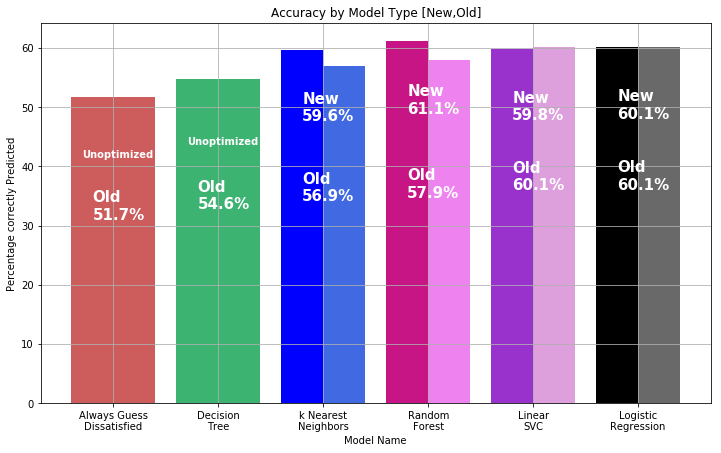

In [42]:
# Graphing the model accuracy results including optimized hyperparameters
x_dist = 2*np.linspace(1,len(model_values_new),num=len(model_values_new))
fig, ax = plt.subplots(figsize=(12,7))
ax.grid()
bar_width=0.8
text_settings={'color':'white', 'fontweight':'bold','fontsize':15}


plt.bar(x_dist-bar_width/2,model_values_new,width=bar_width,color=colors_for_plots_2[:2]+colors_for_plots[2:len(model_values_new)])
plt.bar(x_dist+bar_width/2,model_values_old,width=bar_width,color=colors_for_plots_2[:len(model_values_old)])

plt.xticks(x_dist,model_names)
plt.title("Accuracy by Model Type [New,Old]")
plt.xlabel('Model Name')
plt.ylabel('Percentage correctly Predicted')
for ind,score in enumerate(model_values_new):
    if ind<2:
        ax.text(x_dist[ind]-.6,score-.2*score,'Unoptimized',color='white',fontweight='bold',fontsize=10)
    else:
        ax.text(x_dist[ind]-.4,score-.2*score,'New\n'+str(score)[:4]+'%',**text_settings)
for ind,score in enumerate(model_values_old):
    ax.text(x_dist[ind]-.4,score-.4*score,'Old\n'+str(score)[:4]+'%',**text_settings)

**The Random forest model has the best performance out of all the models**

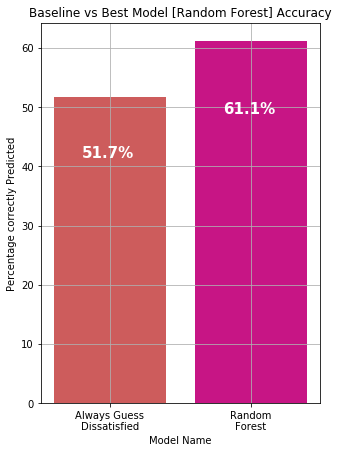

In [43]:
model_scores_list_2.sort(key= lambda x: x[1])
model_values_min_max = [100*model_scores_list_2[0][1],100*model_scores_list_2[-1][1]]
model_names = [model_scores_list_2[0][0],model_scores_list_2[-1][0]]

x_dist = [1,2]
fig, ax = plt.subplots(figsize=(5,7))
ax.grid()
bar_width=0.8
text_settings={'color':'white', 'fontweight':'bold','fontsize':15}


plt.bar(x_dist,model_values_min_max,width=bar_width,color=[colors_for_plots_2[0],colors_for_plots[3]])
plt.xticks(x_dist,model_names)
plt.title("Baseline vs Best Model [Random Forest] Accuracy")
plt.xlabel('Model Name')
plt.ylabel('Percentage correctly Predicted')
for ind,score in enumerate(model_values_min_max):
    ax.text(x_dist[ind]-.2,score-.2*score,str(score)[:4]+'%',**text_settings)


### Most important features in the Random Forest Model

In [45]:
#Generating the most important features in the Random Forest Model
best_model = RandomForestClassifier(n_estimators=45,min_samples_leaf=32,min_samples_split=15,
                                    max_depth=11,n_jobs=-1,random_state=40,warm_start=True)
best_model.fit(X,y)

random_forest_important_features = []
for i,j in zip(X.columns,best_model.feature_importances_):
    random_forest_important_features.append((i,j))
random_forest_important_features.sort(key=lambda x: x[1],reverse=True)
random_forest_important_features

[('Q9', 0.11794501564473957),
 ('Q5', 0.10194924894210242),
 ('Q66A', 0.081900554916718118),
 ('Q66G', 0.071720144011348866),
 ('Q66F', 0.056913915186745052),
 ('Q133', 0.053063357706151275),
 ('Q66C', 0.050179871844545469),
 ('Q66B', 0.048209015018228524),
 ('Q10', 0.045964945025998266),
 ('Q66D', 0.043422826733308752),
 ('Q66E', 0.038944797313309576),
 ('Q11', 0.031638604319223107),
 ('Q23B', 0.030983336767094069),
 ('Q23A', 0.030572368710611256),
 ('Q13B', 0.02770077646226729),
 ('Q13A', 0.026298737227093257),
 ('Q23D', 0.022266946798177818),
 ('Q27', 0.0213130441125031),
 ('Q23C', 0.020864622123156561),
 ('Q28', 0.020062705162229848),
 ('Q77B', 0.01875506746425909),
 ('Q30', 0.01690375397969435),
 ('Q132', 0.012859843118213522),
 ('Q153', 0.0095665014122808534)]

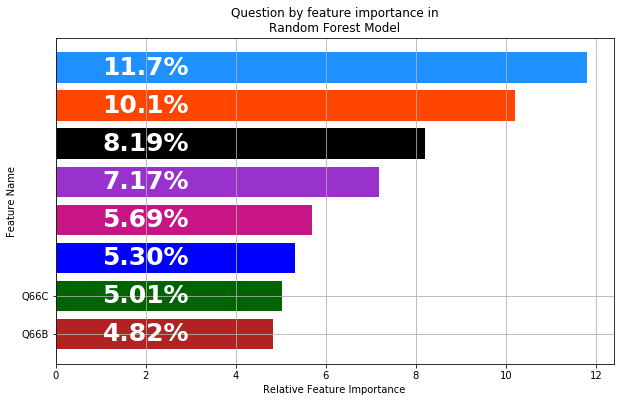

In [46]:
# Graphing the the most important features in the Random Forest Model
# based on relative contribution to overall model

forest_classifier_name = [x[0] for x in random_forest_important_features][:8]
forest_classifier_importance = [100*x[1] for x in random_forest_important_features][:8]
forest_classifier_name = list(reversed(forest_classifier_name))
forest_classifier_importance = list(reversed(forest_classifier_importance))

y_dist = np.linspace(1,len(forest_classifier_name),num=len(forest_classifier_name))
fig, ax = plt.subplots(figsize=(10,6))
ax.grid()
bar_width=0.8
text_settings={'color':'white', 'fontweight':'bold','fontsize':25}

plt.barh(y_dist,forest_classifier_importance,height=bar_width,
        color=colors_for_plots[:len(forest_classifier_importance)])
plt.yticks(x_dist,forest_classifier_name)
plt.title("Question by feature importance in\nRandom Forest Model")
plt.ylabel('Feature Name')
plt.xlabel('Relative Feature Importance')
for ind,imp in enumerate(forest_classifier_importance):
    ax.text(2,y_dist[ind],str(imp)[:4]+'%',ha='center',va='center',**text_settings)

In [47]:
# Most important question features in order of importance, descending
for feat in list(reversed(forest_classifier_name)):
    print(f"{q_full_dict[feat].decode()}\n")

Q9. Now thinking about our economic situation, how would you describe the current economic situation in (survey country) – is it very good, somewhat good, somewhat bad or very bad?  

Q5. Overall, are you satisfied or dissatisfied with the way things are going in our country today? 

Q66A. On a scale of 0 to 10, in your opinion, how important is it to have a good education to get ahead in life, where 0 means not important at all and 10 means very important?

Q66G. On a scale of 0 to 10, in your opinion, how important is it to be lucky to get ahead in life, where 0 means not important at all and 10 means very important?

Q66F. On a scale of 0 to 10, in your opinion, how important is it to belong to a wealthy family to get ahead in life, where 0 means not important at all and 10 means very important?

Q133. How old were you at your last birthday?

Q66C. On a scale of 0 to 10, in your opinion, how important is it to know the right people to get ahead in life, where 0 means not important a

### Analyzing confusion matrices and ROC Curves

The following section has a ROC curve for the random forest and some addtional statistics about model strength based on custom thresholds.

In [49]:
#generating a dataframe containing proba_values for every row in dataset
#NOTE: the models were generated using crossvalidation
y_with_thresholds = pd.DataFrame({'orig_y':y})
y_with_thresholds['proba_values']=[i[1] for i in list(best_model.predict_proba(X))]

In [50]:
y_with_thresholds.sample(5,random_state=100)

,orig_y,proba_values
45897,Dissatisfied,0.387018
29357,Satisfied,0.560456
11065,Satisfied,0.303801
41749,Satisfied,0.573471
15854,Satisfied,0.662050


In [51]:
fpr,tpr,thresh=roc_curve(y_with_thresholds['orig_y'],y_with_thresholds['proba_values'],pos_label='Satisfied')

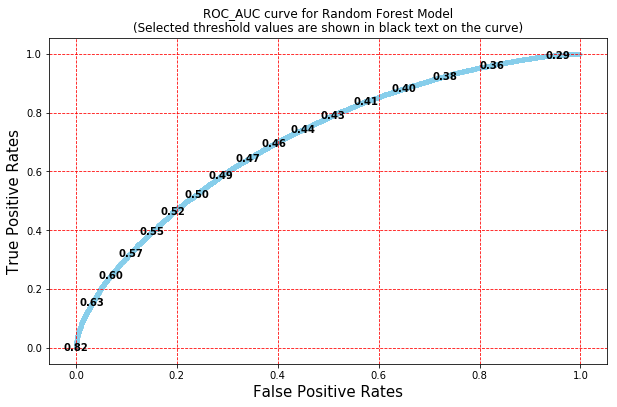

In [52]:
fig, ax = plt.subplots(figsize=(10,6))
x_dist=np.linspace(0,1,11)
ax.grid(color='r',linestyle='--')
text_settings={'color':'black', 'fontweight':'bold','fontsize':10}

plt.scatter(fpr,tpr,marker='.',color='skyblue')
plt.title("ROC_AUC curve for Random Forest Model\n(Selected threshold values are shown in black text on the curve)")
plt.ylabel('True Positive Rates',fontsize=15)
plt.xlabel('False Positive Rates',fontsize=15)
skip=1200
for fpr0,tpr0,trs in zip(fpr[::skip],tpr[::skip],thresh[::skip]):
    ax.text(fpr0,tpr0,str(trs)[:4],ha='center',va='center',**text_settings)

In [53]:
threshold_vals=[0.35,0.4,0.45,0.5,0.55,0.6]
threshold=int
conf_matrix_dict = defaultdict(np.array)

In [54]:
def predictions_with_threshold(row):
    """
    Helper function to create a new column on a dataframe with outputs set according to a threshold boundary
    """
    if row['proba_values']>=threshold:
        return 'Satisfied'
    else:
        return 'Dissatisfied'

def create_conf_mat(threshold):
    """
    generate a confusion matrix based on a threshold boundary
    """
    cm_name= f"cm_{threshold}"
    conf_matrix_dict['cm_name']=confusion_matrix(y_with_thresholds['orig_y'],
                                                 y_with_thresholds[f'threshold={threshold}'],
                                                 labels=['Dissatisfied','Satisfied'])
    return conf_matrix_dict['cm_name']
    
def conf_mat_score(conf_mat):
    """
    returns accuracy, precision, recall, and F1 scores based on a confusion matrix
    """
    tn=conf_mat[0][0]
    tp=conf_mat[1][1]
    fn=conf_mat[0][1]
    fp=conf_mat[1][0]
    accuracy = (tp+tn)/conf_mat.sum()
    recall_dis = (tn)/(tn+fp)
    recall_sat = (tp)/(fn+tp)
    prec_dis = tn/(tn+fn)
    prec_sat = tp/(tp+fp)
    f1_score_dis = 2*recall_dis*prec_dis/(recall_dis+prec_dis)
    f1_score_sat = 2*recall_sat*prec_sat/(recall_sat+prec_sat)
    print(f'###################\
          \nThreshold = {threshold}\
          \nAccuracy: {accuracy}\n')
    print(f"Recall satisfied: {recall_sat}\
          \nPrecision satisfied: {prec_sat}\
          \nF1 Score satisfied: {f1_score_sat}\n")
    print(f"Recall dissatisfied: {recall_dis}\
          \nPrecision dissatisfied: {prec_dis}\
          \nF1 Score dissatisfied: {f1_score_dis}")
    print(f'###################\n')

In [56]:
for threshold in threshold_vals:
    y_with_thresholds[f'threshold={threshold}']=y_with_thresholds.apply(predictions_with_threshold,axis=1)
    conf_matrix = create_conf_mat(threshold)
    conf_mat_score(conf_matrix)
    

###################          
Threshold = 0.35          
Accuracy: 0.5424619701997817

Recall satisfied: 0.5136269366841527          
Precision satisfied: 0.9718836565096953          
F1 Score satisfied: 0.672072791124591

Recall dissatisfied: 0.844404701073071          
Precision dissatisfied: 0.14221782348638065          
F1 Score dissatisfied: 0.2434353478437005
###################

###################          
Threshold = 0.4          
Accuracy: 0.6033319227599724

Recall satisfied: 0.5554467423238666          
Precision satisfied: 0.8903047091412742          
F1 Score satisfied: 0.6840966334385753

Recall dissatisfied: 0.7666241037226206          
Precision dissatisfied: 0.33585782520762514          
F1 Score dissatisfied: 0.467085577498504
###################

###################          
Threshold = 0.45          
Accuracy: 0.6447805073609657

Recall satisfied: 0.6095950873152945          
Precision satisfied: 0.7332871652816251          
F1 Score satisfied: 0.6657445247825631

## Visualizing Satisfaction by Country

**The purpose of this next section is to visualize levels of satisfaction on a country to country basis**

In [57]:
satisfaction_by_country = dummies_df.loc[:,['satisfaction_rating','COUNTRY']]

country_dict=q_responses_dict['COUNTRY']
def country_from_code(row):
    """
    A function that takes in the country's PEW Survey code and returns the 
    """
    return country_dict[row['COUNTRY']].decode()

In [58]:
#Creating dataframe with country-level satisfaction/dissatisfaction
satisfaction_by_country['country_name']=satisfaction_by_country.apply(country_from_code,axis=1)
satisfaction_groupby_country = pd.DataFrame(satisfaction_by_country.groupby(['country_name','satisfaction_rating'])['satisfaction_rating'].count())
satisfaction_groupby_country.columns = ['satisfaction_count']
satisfaction_groupby_country.reset_index(inplace=True)
satisfaction_groupby_country_dis = satisfaction_groupby_country[satisfaction_groupby_country['satisfaction_rating']=='Dissatisfied']
satisfaction_groupby_country_dis.columns=['country_name','satisfaction_rating','dissatisfaction_count']
satisfaction_groupby_country_sat = satisfaction_groupby_country[satisfaction_groupby_country['satisfaction_rating']=='Satisfied']
satisfaction_groupby_country = pd.merge(satisfaction_groupby_country_dis,satisfaction_groupby_country_sat,on='country_name')
satisfaction_groupby_country = satisfaction_groupby_country[['country_name','satisfaction_count','dissatisfaction_count']]
satisfaction_groupby_country['total_responses'] = satisfaction_groupby_country['satisfaction_count']+satisfaction_groupby_country['dissatisfaction_count']
satisfaction_groupby_country['%satisfied']=satisfaction_groupby_country['satisfaction_count']*100/satisfaction_groupby_country['total_responses']
satisfaction_groupby_country['%dissatisfied']=satisfaction_groupby_country['dissatisfaction_count']*100/satisfaction_groupby_country['total_responses']
satisfaction_groupby_country.sort_values('%satisfied',ascending=False).head()

,country_name,satisfaction_count,dissatisfaction_count,total_responses,%satisfied,%dissatisfied
20,Mexico,746,199,945,78.941799,21.058201
41,Venezuela,693,250,943,73.488865,26.511135
14,Israel,701,254,955,73.403141,26.596859
2,Brazil,724,269,993,72.910373,27.089627
40,United States,632,274,906,69.757174,30.242826


In [59]:
# dataframe of ISO-3 codes for countries. Needed for graphing on plotly choropleth map.
# Certain countries need their names manually changed in order to merge properly with the satisfaction dataframe.

#requires requests module imported in the initializations
url = 'http://www.nationsonline.org/oneworld/country_code_list.htm'
html = requests.get(url).content
df_list = pd.read_html(html,header=0)
df_countries = df_list[2]
df_countries = df_countries[['Country or Area Name','ISO ALPHA-3 Code']].iloc[1:,:]
df_countries.columns = ['country', 'ISO-3']

# merge the ISO codes with the satisfaction_groupby_country dataframe 
satisfaction_df_with_codes = pd.merge(satisfaction_groupby_country,df_countries,how='left',left_on='country_name',right_on='country',indicator=True)

# Unfortunately some of the countries in the original dataframe have
#country names that are slightly different than the ones that were extracted from the web
# so we have to manually change them
nan_entries = pd.isnull(satisfaction_df_with_codes).any(axis=1)
countries_tochange = list(satisfaction_df_with_codes[nan_entries].country_name)

iso_countries_incompatible = ['Palestinian Territory','Russian Federation','Korea (South)',
                 'Tanzania, United Republic of','United States of America',
                'Venezuela (Bolivarian Republic)','Viet Nam']

modified_iso_countries = df_countries.loc[df_countries.country.isin(iso_countries_incompatible)]

modified_iso_countries['country']=[countries_tochange[2],
                                   countries_tochange[0],
                                   countries_tochange[1],
                                   countries_tochange[3],
                                   countries_tochange[4],
                                   countries_tochange[5],
                                   countries_tochange[6]]

for country,ISO3 in zip(modified_iso_countries['country'],modified_iso_countries['ISO-3']):
    satisfaction_df_with_codes.set_value(satisfaction_df_with_codes[satisfaction_df_with_codes.country_name==country].index,'ISO-3',ISO3)

satisfaction_df_with_codes = satisfaction_df_with_codes.loc[:,['country_name','ISO-3','total_responses','%satisfied','%dissatisfied']]
satisfaction_df_with_codes.head()

/home/farhaan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,country_name,ISO-3,total_responses,%satisfied,%dissatisfied
0,Argentina,ARG,923,67.388949,32.611051
1,Bangladesh,BGD,983,33.570702,66.429298
2,Brazil,BRA,993,72.910373,27.089627
3,Chile,CHL,925,56.972973,43.027027
4,China,CHN,2983,61.582300,38.417700


In [60]:
satisfaction_df_with_codes['text'] = satisfaction_df_with_codes['country_name'] + '<br>' +\
                                    'Percent Dissatisfied '+satisfaction_df_with_codes['%dissatisfied'].map(str)+'%'
data = [ dict(
        type = 'choropleth',
        locations = satisfaction_df_with_codes['ISO-3'],
        z = satisfaction_df_with_codes['%satisfied'],
#         text = satisfaction_df_with_codes['country_name']
        text= satisfaction_df_with_codes['text'],
        colorscale = [[0,'maroon'],[0.7,'lightgrey'],[1,'navy']],
#         colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
#             [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
#         autocolorscale = False,
#         reversescale = True,
        marker = dict(
            line = dict (
                 color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            #tickprefix = '$',
            ticksuffix = '%',
            title = 'Percent Satisfied'),
      ) ]

layout = dict(
    title = '2014 Satisfaction by Country<br>Source:\
            <a href="http://www.pewglobal.org/2014/06/05/spring-2014-survey-data/">\
            PEW</a>',
    geo = dict(
        showframe = False,
        showcoastlines = True,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='d3-world-map' )

## Appendix

In [ ]:
# Some of the code used during hyperparameter optimization : NOT COMPREHENSIVE

# logregression_grid_params = {'n_jobs':[-1], 'penalty':['l1','l2'],
#                              'C':np.logspace(-2,1,6), 'random_state':[40]}

# logregression_grid_search = GridSearchCV(LogisticRegression(),logregression_grid_params,
#                                         n_jobs=-1,cv=cross_validator)

# logregression_grid_search.fit(X,y)

# logregression_grid_search.best_score_

# logregression_grid_search.best_params_

# logregression_grid_search.grid_scores_

# linearsvc_grid_params = {'C':np.logspace(-2,2,5), 'penalty':['l2'],
#                          'loss':['hinge','squared_hinge'],'random_state':[40]}

# linearsvc_grid_search = GridSearchCV(LinearSVC(),linearsvc_grid_params,
#                                      n_jobs=-1,cv=cross_validator)

# linearsvc_grid_search.fit(X2,y2)

# linearsvc_grid_search.best_score_

# linearsvc_grid_search.best_params_



# print(linearsvc_grid_search.best_score_)
# print(linearsvc_grid_search.best_params_)

# knn_grid_params = {'n_neighbors':[15], 'weights':['uniform','distance'],
#                    'leaf_size':[40],'n_jobs':[-1],}

# knn_grid_search = GridSearchCV(KNeighborsClassifier(),knn_grid_params,
#                                n_jobs=-1,cv=cross_validator)

# knn_grid_search.fit(X2,y2)

# print(knn_grid_search.best_score_)
# print(knn_grid_search.best_params_)

# knn_grid_search.grid_scores_

# knn_grid_params = {'n_neighbors':[20,40], 'algorithm':['ball_tree'],'weights':['uniform'],
#                    'leaf_size':[40,100],'n_jobs':[-1],}

# knn_grid_search = GridSearchCV(KNeighborsClassifier(),knn_grid_params,
#                                n_jobs=-1,cv=cross_validator)

# knn_grid_search.fit(X2,y2)

# print(knn_grid_search.best_score_)
# print(knn_grid_search.best_params_)